### Run these first!

In [9]:
library(tidyverse)
library(repr)
library(tidymodels)
set.seed(900)

### Introduction

Heart disease can be diagnosed through angiograms, xrays that look at the heart, major arteries and blood vessels. Angiograms typically range from \\$675-$2200 CAD. What if there was an easier and cheaper way to diagnose heart disease?

In this project we consider attributes that can be observed using only a simple checkup and blood test: blood pressure, cholesterol levels, age, and maximum heart rate. Can we use blood pressure, cholesterol levels, age, and maximum heart rate to determine if a patient has heart disease?

The dataset used contains 14 attributes we can use for data analysis, varying from identifiers like age or sex to max heart rate or cholesterol levels. The dataset contains data from 4 different locations: Cleveland, Hungary, Switzerland, and the VA Long Beach. In our analysis we used the Cleveland and Hungary datasets. 

### Methods

The variables of importance were age, resting blood pressure, cholesterol levels, and maximum heart rate. Observations for these variables can be obtained cheaply, and they appear to have some correlation to the presence of heart disease. 

We will display the correlations between our variables and heart disease using tables and scatterplots. Scatterplots are an effective way to visualize relationships between multiple continuous variables.

### Preliminary exploratory data analysis 

---



In [10]:
#reads the raw data sets and converts them into tibbles with no column names
cleveland_data <- read_delim('https://raw.githubusercontent.com/xonew/DSCI-100-002-Group-26/main/Data/processed.cleveland.data',
                             col_names = FALSE) |> as_tibble()
hungarian_data <- read_delim('https://raw.githubusercontent.com/xonew/DSCI-100-002-Group-26/main/Data/processed.hungarian.data',
                             col_names = FALSE) |> as_tibble()

#combines the two data sets into one
heart_data <- rbind(cleveland_data, hungarian_data)

#assigns names to the columns based on information from the website
colnames(heart_data) <- c('age', 'sex', 'chest_pain', 'trestbps', 'chol', 'fbs', 'restecg', 'max_hr', 
              'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num') 

#In the Cleveland data set, presence of heart disease is ranked on a 1-4 scale, for our work, we dont need the scale,
#we only need 0 = no heart disease, 1 = heart disease present. This code converts all num values > 1 (heart disease present) to 1
heart_data <- mutate(heart_data, num = replace(num, num > 0, 1))

#converts all categorical attributes into factors
heart_data <- mutate(heart_data, sex = as.factor(sex), chest_pain = as.factor(chest_pain), 
    num = as.factor(num), fbs = as.factor(fbs), restecg = as.factor(restecg), 
    exang = as.factor(exang), thal = as.factor(thal), slope = as.factor(slope), ca = as.factor(ca)) |>

#removes missing values from the cholesterol and resting blood pressure columns
filter(chol != '?', trestbps != '?') |>

#converts all necessary numerical attributes into doubles
mutate(chol = as.double(chol), trestbps = as.double(trestbps), max_hr = as.double(max_hr))

#splits data into testing and training sets
heart_split <- initial_split(heart_data, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

head(heart_train)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain,trestbps,chol,fbs,restecg,max_hr,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
57,1,4,140,192,0,0,148,0,0.4,2,0.0,6.0,0
44,1,2,120,263,0,0,173,0,0.0,1,0.0,7.0,0
52,1,3,172,199,1,0,162,0,0.5,1,0.0,7.0,0
57,1,3,150,168,0,0,174,0,1.6,1,0.0,3.0,0


In [23]:
disease_stats <- heart_data |>
        group_by(num) |>
        summarize(count = n()) |> 
        mutate(ratio = round(100 *(count/573)))
disease_stats

heart_stats <- heart_data |> 
        summarize(avg_max_hr = round(mean(max_hr), digits = 2), avg_chol = round(mean(chol), digits = 2),
                  avg_bps = round(mean(trestbps), digits = 2))
heart_stats

num,count,ratio
<fct>,<int>,<dbl>
0,333,58
1,240,42


avg_max_hr,avg_chol,avg_bps
<dbl>,<dbl>,<dbl>
144.68,248.55,132.07


The first table displays the number of individuals with and without heart disease and the overall ratios. num = 0 represents individuals without heart disease, and num = 1 is individuals with heart disease. The second table shows the rounded average values of maximum heart rate, cholesterol levels, and resting blood pressure.

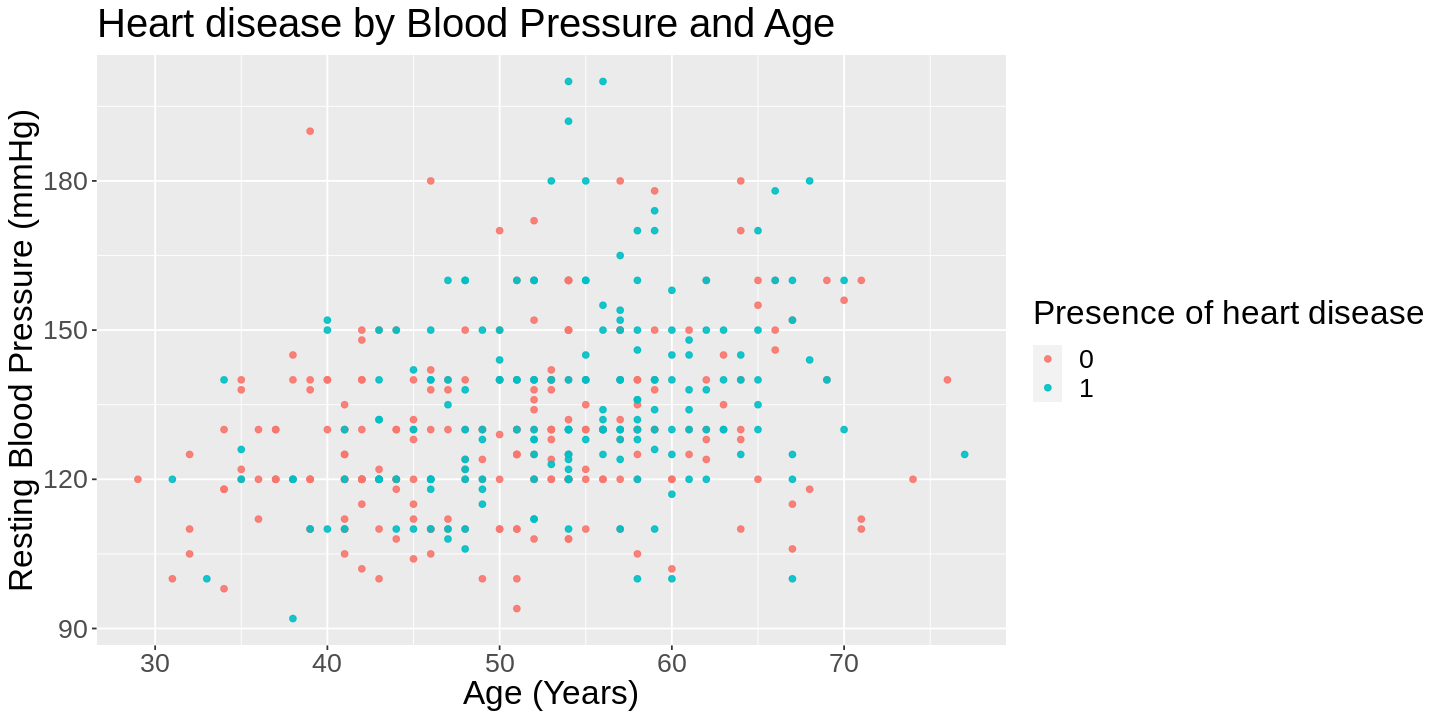

In [4]:
options(repr.plot.width = 12, repr.plot.height = 6)
heart_plot_age_bps <- heart_train |>
                ggplot(aes(x = trestbps, y = age, color = num)) +
                geom_point(alpha = 0.9) +
                theme(text = element_text(size = 20)) +
                labs (x = 'Resting Blood Pressure (mmHg)', y = "Age (Years)", colour = "Presence of heart disease") +
                ggtitle("Heart disease by Blood Pressure and Age") +
                coord_flip()
heart_plot_age_bps

With this scatterplot, there is a weak positive correlation between age and resting blood pressure, and that there is a higher presence of heart disease in older individuals with higher resting blood pressures.

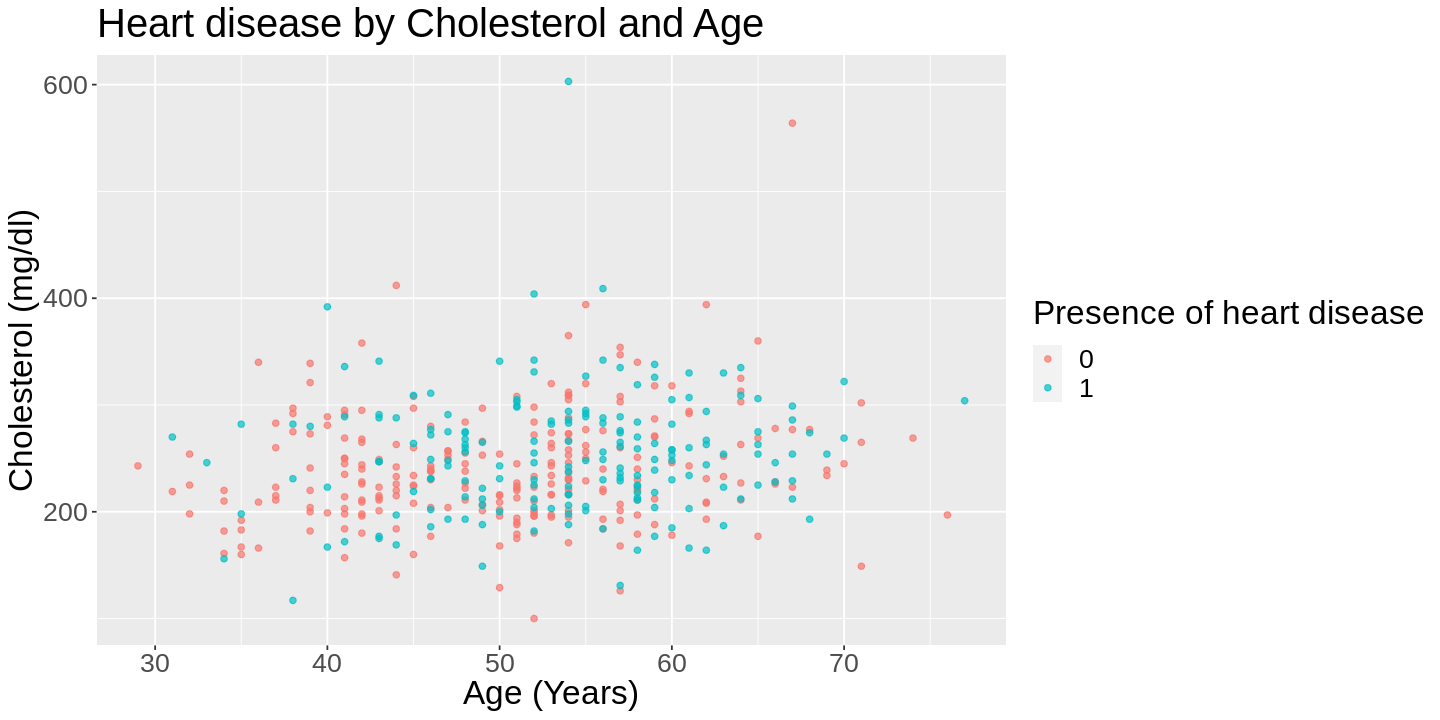

In [5]:
heart_plot_age_chol <- heart_train |>
                ggplot(aes(x = chol, y = age, color = num)) +
                geom_point(alpha = 0.7) +
                theme(text = element_text(size = 20)) +
                labs (x = 'Cholesterol (mg/dl)', y = "Age (Years)", colour = "Presence of heart disease") +
                ggtitle("Heart disease by Cholesterol and Age") +
                coord_flip()
heart_plot_age_chol

With this scatterplot, there is a weak positive correlation between age and cholesterol levels, and that there is a higher presence of heart disease in older individuals with higher cholesterol levels.

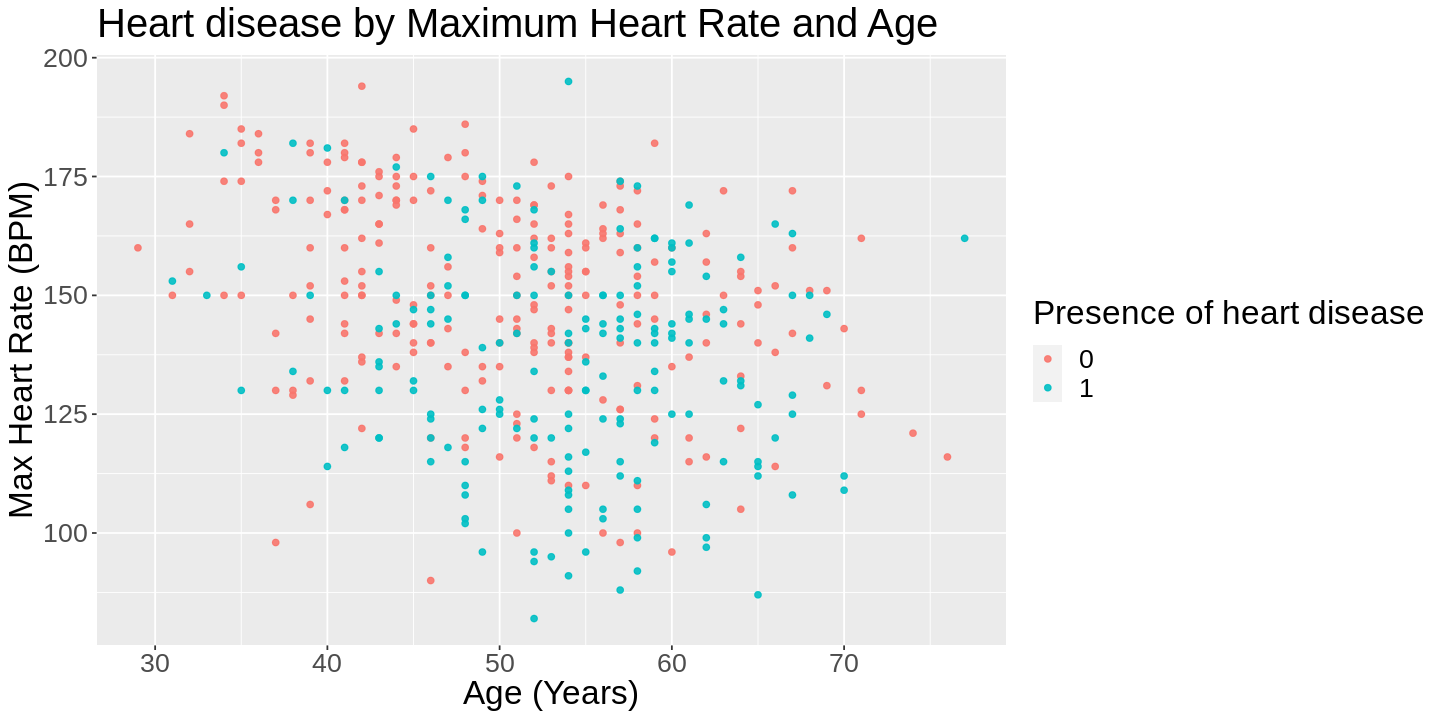

In [6]:
heart_plot_age_maxhr <- heart_train |>
                ggplot(aes(x = max_hr, y = age, color = num)) +
                geom_point(alpha = 0.9) +
                theme(text = element_text(size = 20)) +
                labs (x = 'Max Heart Rate (BPM)', y = "Age (Years)", colour = "Presence of heart disease") +
                ggtitle("Heart disease by Maximum Heart Rate and Age") +
                coord_flip()
heart_plot_age_maxhr

With this scatterplot, there is a weak negative correlation between age and max heart rate, and that there is a higher presence of heart disease in older individuals with smaller max heart rates.

Each variable is weakly related to heart disease on its own. The goal of this project is to see if the *combination* of each of these variables is enough to make accurate heart disease diagnoses. 

### Expected Outcomes and Significance

Based on preliminary research, we determined that there's a relationship between heart disease and all of our selected variables. So, we expect that using all four predictors will allow us to predict heart disease diagnosis with decent accuracy. We are testing to see if we can predict whether a patient has heart disease based purely off of these cheap to test for variables.

The impact is clear: if we can diagnose heart disease without an angiogram, it means less costly procedures for physicians and patients, leading to increased access to heart disease diagnoses.

Future questions may allow us to rethink current standard diagnosis practices in medicine and explore easier, less expensive options. If this project is successful, one possible question is *"What other variables can we use to successfully predict heart disease with even more accuracy?"*